# Forecasting with HCrystalBall forecaster
This tutorial shows, how to use [HCrystalBall](https://github.com/heidelbergcement/hcrystalball)'s compliant estimator within `sktime` eco-system for the time-series forecasting. 

There is an existing [documentation](https://hcrystalball.readthedocs.io/en/latest/) containing full set of features (also with [tutorial](https://hcrystalball.readthedocs.io/en/latest/examples/02_tutorial.html)), so the main goal of this notebook is highlighting differences and additions to `sktime` possibilites.

## Setup
`hcrystalball` is a soft dependency, that you would need to install with `conda install -c conda-forge hcrystalball` or `pip install hcrystalball`

## Usage in sktime

In [1]:
from warnings import simplefilter

import numpy as np

simplefilter("ignore", FutureWarning)

In [2]:
from sktime.datasets import load_airline
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import smape_loss
from sktime.utils.plotting import plot_series

In [3]:
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)
print(y_train.shape[0], y_test.shape[0])

108 36


In [4]:
from hcrystalball.ensemble import SimpleEnsemble
from hcrystalball.wrappers import (
    ExponentialSmoothingWrapper,
    SarimaxWrapper,
    get_sklearn_wrapper,
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet

from sktime.forecasting.hcrystalball import HCrystalBallForecaster

In [5]:
models = {
    "sarimax": SarimaxWrapper(init_with_autoarima=True, autoarima_dict={"m": 12}),
    "smoothing": ExponentialSmoothingWrapper(
        trend="add", seasonal="multiplicative", seasonal_periods=12
    ),
    "sklearn_linear": get_sklearn_wrapper(ElasticNet),
    "sklearn_forest": get_sklearn_wrapper(RandomForestRegressor, n_estimators=100),
    "avg_ensemble": SimpleEnsemble(
        base_learners=[
            get_sklearn_wrapper(ElasticNet, name="sklearn_linear"),
            ExponentialSmoothingWrapper(
                trend="add",
                seasonal="multiplicative",
                seasonal_periods=12,
                name="smoothing",
            ),
        ],
        ensemble_func="mean",
    ),
}

In [6]:
# from hcrystalball.feature_extraction import HolidayTransformer, SeasonalityTransformer
# from hcrystalball.wrappers import ProphetWrapper

# other_models = {
#     # needs fbprophet with its dependencies installed
#     "prophet": ProphetWrapper(),
#     # works only with daily data frequency
#     "sklearn_forest_holiday": Pipeline(
#         [
#             ("seasonality", SeasonalityTransformer(freq="M")),
#             (
#                 "holiday",
#                 HolidayTransformer(
#                     country_code="DE", days_before=2, days_after=1, bridge_days=True
#                 ),
#             )("model", get_sklearn_wrapper(RandomForestRegressor)),
#         ]
#     ),
# }

In [7]:
fh = np.arange(len(y_test)) + 1

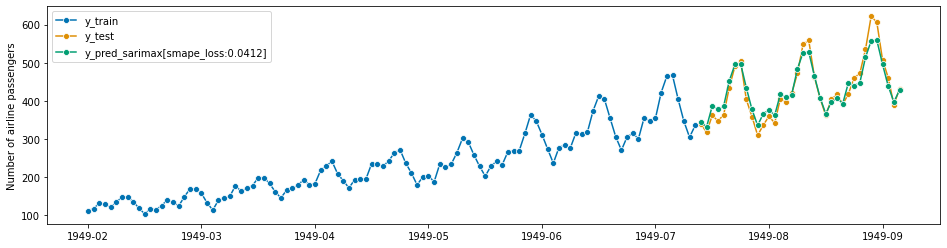

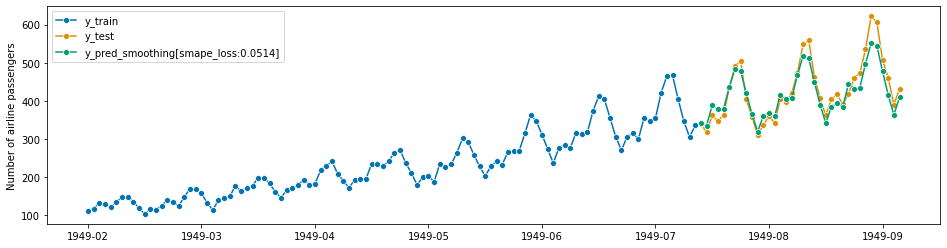

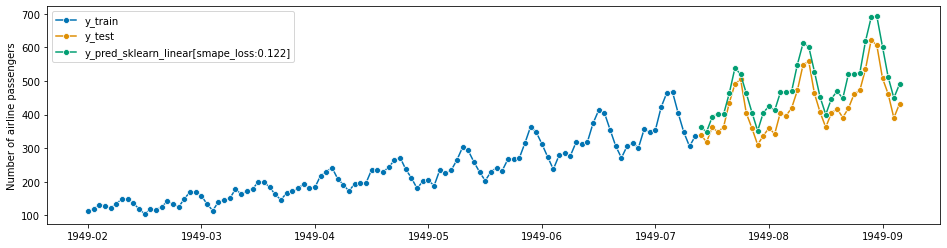

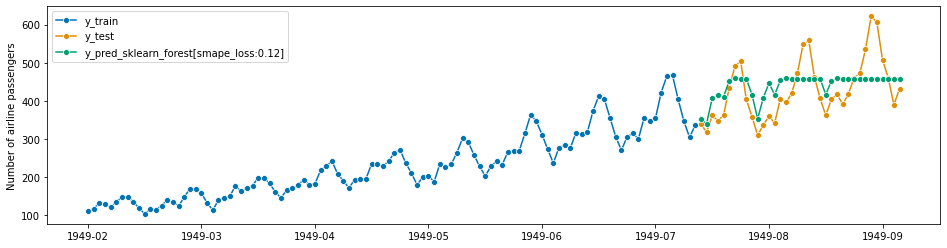

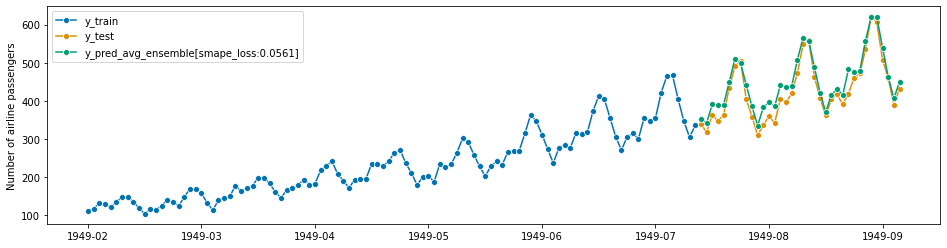

In [10]:
for model_name, model in models.items():
    forecaster = HCrystalBallForecaster(model)
    # if provided in the data, exogenous variables are supported over X_train, X_pred
    forecaster.fit(y_train)
    y_pred = forecaster.predict(fh)
    plot_series(
        y_train,
        y_test,
        y_pred,
        labels=[
            "y_train",
            "y_test",
            f"y_pred_{model_name}[smape_loss:{smape_loss(y_pred, y_test):.3}]",
        ],
    )

*Note: As we see, the `RandomForestRegressor` does not cope well with trended data (cannot predict value from before unseen range). Adding detrender and other features might be used here.*

## Main Functionality

### HolidayTransformer
 - create feature for **holidays** given county ISO code (optionally also region, e.g. DE-NW) from the **day** (data need to have **daily frequency**)
 - allows simple modelling of **before and after holidays effects** (use-case: "Our company does not sell much in the **Christmas time period**")
 - allows usage of **multiple holiday codes** (use-case: "Our company is located at the borders, having sales influenced by holidays in **Germany and France**")
 - [see examples](https://hcrystalball.readthedocs.io/en/latest/examples/tutorial/wrappers/04_seasonalities_and_holidays.html)

### SeasonalityTransformer
 - create features for day of the week and similar
 - can be automatically inferred from the data frequency

### ProphetWrapper
 - wrapper for [fbprophet](https://facebook.github.io/prophet/) library
 - [learn more on the usage](https://hcrystalball.readthedocs.io/en/latest/examples/tutorial/wrappers/06_advanced_prophet.html)

>_Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well._

>_Taylor SJ, Letham B. 2017. [Forecasting at scale](https://doi.org/10.7287/peerj.preprints.3190v2). PeerJ Preprints 5:e3190v2 https://doi.org/10.7287/peerj.preprints.3190v2_
 
### StackingEnsemble
 - own implementation of stacked ensemble
 - meta model allows for having (apart from predictions from base models) features for weekday and horizon
 - (use-case: **exponential smoothing is better in modelling short horizon, while sklearn for long ones, meta model might pick that information**)
 - [learn more](https://hcrystalball.readthedocs.io/en/latest/examples/tutorial/wrappers/08_ensembles.html#Stacking-Ensembles)

### SklearnWrapper
 - own implementation of sklearn compatible regressors -> to time-series forecasters
 - uses lags depending on the forecasting horizon, that needs to be know already at the fitting time
 - [learn more](https://hcrystalball.readthedocs.io/en/latest/examples/tutorial/wrappers/02_ar_modelling_in_sklearn.html)

### TBATSWrapper
 - wrapper for [tbats](https://github.com/intive-DataScience/tbats) library
 - python implementation of methods for complex seasonal patterns
 
>_De Livera, A.M., Hyndman, R.J., & Snyder, R. D. (2011), Forecasting time series with complex seasonal patterns using exponential sm_oothing, Journal of the American Statistical Association, 106(496), 1513-1527._

## Performance 
Depending on the dataset (frequency, additonal features, trend, seasonality, ...), there are certain things that (dis)allow for usage of different techinques. Take a look at the [HCrystalBall docs]((https://hcrystalball.readthedocs.io/en/latest/examples/02_tutorial.html)) to see performance on the **daily data** with **exogenous variables** and **holiday** information (domain HCrystalBall was mainly developed against)